**Anomaly Detection**: 

The present project can be found by clicking the following link:

https://www.kaggle.com/competitions/anomaly-detection

In [35]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import os
from imblearn.over_sampling import SMOTE

import opendatasets as od

#_______Scaling_______________
from sklearn.preprocessing import StandardScaler, RobustScaler

#___________Clasification________________
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#______Metric___________
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, roc_curve
from sklearn.metrics import roc_curve
#from sklearn.metrics import roc_auc_curve
from sklearn import metrics

In [36]:
def create_file():
    try:
        if not os.path.exists('data'):
            od.download("https://www.kaggle.com/competitions/anomaly-detection")
            os.rename(os.listdir()[0],'data')
            #os.remove('./data/mass_shootings.csv')
    except Exception as e:
        print('Failed to create or deleted')

create_file()

In [37]:
for (dirpath, dirnames, filenames) in os.walk('./'):
    for filename in filenames:
        if filename.endswith('.csv'):
            name_file = filename
            if name_file == 'train.csv':
                os.rename(dirpath + '/'+ filename, dirpath +'/'+'anomaly.csv')
                address = "".join(dirpath +'/'+'anomaly.csv')
            else:
                address = "".join(dirpath +'/'+'anomaly.csv')

In [38]:
address

'./data/anomaly.csv'

In [39]:
try:
    df = pd.read_csv(address)          
    print(f"Shape of DF: {df.shape}")
except  FileNotFoundError:
    print("Cannot open the file")

Shape of DF: (15830, 4)


In [40]:
df.head()

,timestamp,value,is_anomaly,predicted
0,1425008573,42,False,44.072500
1,1425008873,41,False,50.709390
2,1425009173,41,False,81.405120
3,1425009473,61,False,39.950367
4,1425009773,44,False,35.350160


In [41]:
(df
    .isnull()
    .sum() 
)

timestamp     0
value         0
is_anomaly    0
predicted     0
dtype: int64

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15830 entries, 0 to 15829
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   timestamp   15830 non-null  int64  
 1   value       15830 non-null  int64  
 2   is_anomaly  15830 non-null  bool   
 3   predicted   15830 non-null  float64
dtypes: bool(1), float64(1), int64(2)
memory usage: 386.6 KB


**We inicialize the timestamp to zero and set it as the index**

In [43]:
df.timestamp = df.timestamp-df.timestamp[0]
df= df.set_index("timestamp")

In [44]:
df.head()

,value,is_anomaly,predicted
timestamp,,,
0,42,False,44.072500
300,41,False,50.709390
600,41,False,81.405120
900,61,False,39.950367
1200,44,False,35.350160


In [45]:
# Detect duplicate rows
(
    df
    .index
    .duplicated()
    .sum()
)

0

Counting the number of anomaly events

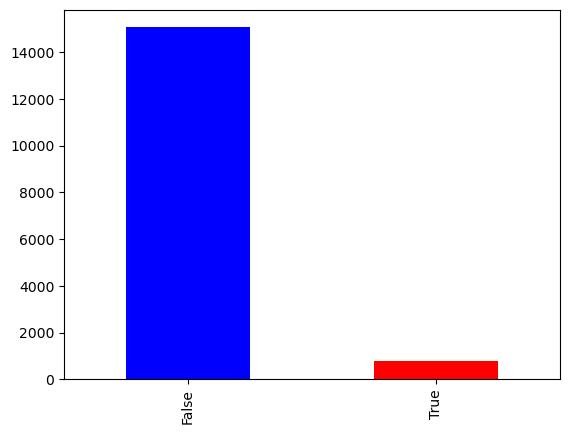

In [46]:
(
    df
    .is_anomaly
    .value_counts()   
    .plot(kind="bar", color=["blue","red"])
)
plt.show()

#  Note that, the number of False cases is higher than True case. 
# Therefore, we conclude that the data is imbalanced and thus we have to solve this problem using SMOTE methodology

#### Turn the logic value *True*  and *False* into one and zero respectively. In addition, to solve the imbalanced data, we use the SMOTE methodology to assure the balance between True and False cases.

In [47]:
mask = {True:1, False:0}
limit = int(0.2*len(df))
y = df.is_anomaly
X = df[['value', 'predicted']]
y = y.map(mask)

#solving the imbalanced problem

smote = SMOTE(random_state=42) 
X_resampled, y_resampled = smote.fit_resample(X, y)

Scaling the data in order to accelerate the convergence during the training

In [48]:
oe = StandardScaler()
#oe = RobustScaler()
X_transformed = oe.fit_transform(X_resampled)


We use several clasification algorithms such as Logistic Regression, Support Vector Machine, Decision Tree and Random Forest in order to obtain the best performance. In this case, Recall score is considered. 

In [49]:
clf_LR = LogisticRegression()
clf_SVC = SVC(kernel='rbf',C=0.1, probability=True)
clf_DT = DecisionTreeClassifier(criterion="entropy",max_depth=20)
clf_RF = RandomForestClassifier(criterion="entropy", max_depth=20)

object_AL = {"LR": clf_LR, 
             "SVM": clf_SVC,
             "DT": clf_DT,
             "RF": clf_RF
            }

metric_result = {}


For the training, we split the data using Time Series Cross-validation 

In [50]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

def metric_algorithm(clf, X, y, key):
    recall  = []
    
    for train_index, test_index in tscv.split(X):

            X_train, X_test = X[:train_index[-1],:], X[:test_index[-1],:]
            y_train, y_test = y[:train_index[-1]], y[:test_index[-1]]
                    
                  
            clf.fit(X_train,y_train)
            y_pred = clf.predict(X_test)
            
            
            
            recall.append(recall_score(y_test, y_pred))

    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    
    
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)

    #create ROC curve
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(key)
    plt.legend(loc=4)
    plt.show()


    return np.mean(recall)
  


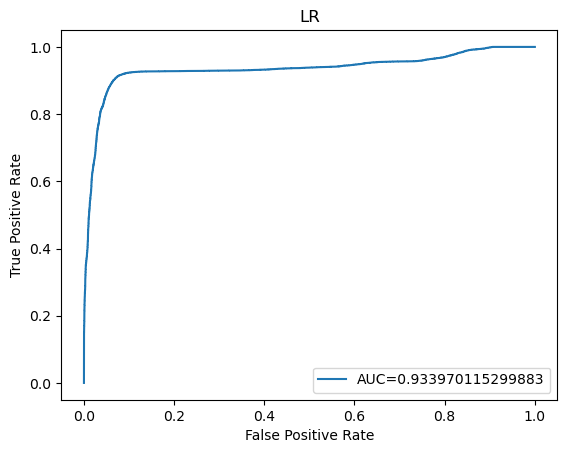

In [51]:
for key, value in object_AL.items():
    metric_result[key] = metric_algorithm(value, X_transformed, y_resampled, key) 
    
df_metric = pd.DataFrame(metric_result.items(), columns = ["AL","Recall"] )    
df_metric.sort_values(by  = ["Recall"],ascending = False)   

Based on Recall score and AUC score we can conclude that Random Forest is the best choice.